<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Crimes" data-toc-modified-id="Crimes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Crimes</a></span></li></ul></li><li><span><a href="#Selection-of-crimes" data-toc-modified-id="Selection-of-crimes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Selection of crimes</a></span><ul class="toc-item"><li><span><a href="#Plot-missing" data-toc-modified-id="Plot-missing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Plot missing</a></span></li></ul></li></ul></div>

**Description**: This notebook contains code to reproduce some of the numbers and figures from the Appendix.

In [1]:
import pickle
import sys
from pathlib import Path

import altair as alt
import pandas as pd

sys.path.append('../..')
from src.prepare_data.crime_database import load_crimes
from src.analysis.figures import format_chart

In [2]:
project_root = Path('../..')
data_path = (project_root / 'data')

In [3]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [4]:
def n_rows(df):
    """Prints number of rows with a ',' as a thousand separator
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe of which number of rows should be printed
        
    Returns
    -------
    Nothing
    """
    print(format(df.shape[0], ','))
    return

In [5]:
project_folder = Path('../..')

# Load data
## Crimes
The loaded dataset contains all the crimes from the raw dataset for the period of the analysis.

In [6]:
query = """select ID, Date, "Primary Type", Latitude, Longitude, "FBI Code"
from crimes
where Date between '2006-01-01' and '2016-06-30'"""
crimes = load_crimes(query, sqldb_path=str(data_path / 'processed/crimes.db'))

In [7]:
n_rows(crimes)

3,736,428


# Selection of crimes

In [8]:
violent_crime = {
    '01A': 'Homicide 1st & 2nd Degree',
    '02': 'Criminal Sexual Assault',
    '03': 'Robbery',
    '04A': 'Aggravated Assault',
    '04B': 'Aggravated Battery'
}
property_crime = {
    '05': 'Burglary',
    '06': 'Larceny',
    '07': 'Motor Vehicle Theft',
    '09': 'Arson'
}

crime_categories = list(violent_crime.keys()) + list(property_crime.keys())

In [9]:
crimes = crimes[crimes['FBI Code'].isin(crime_categories)]
crimes['violent'] = crimes['FBI Code'].isin(list(violent_crime.keys())) * 1

In [10]:
n_rows(crimes)

1,502,468


Number of violent crimes:

In [11]:
format(crimes['violent'].sum(), ',')

'313,250'

Number of property crimes:

In [12]:
format(crimes.shape[0] - crimes['violent'].sum(), ',')

'1,189,218'

In [13]:
crimes.isnull().sum()

ID                  0
Date                0
Primary Type        0
Latitude        14661
Longitude       14661
FBI Code            0
violent             0
dtype: int64

## Plot missing

In [14]:
missing_df = crimes.groupby(
    [crimes['Date'].dt.year,
     'violent']).apply(lambda x: x['Latitude'].isnull().sum()).rename(
         'n_missing').reset_index().rename({
             'violent': 'Crime category'
         }, axis='columns')
missing_df['Crime category'] = missing_df['Crime category'].map({0: 'Property', 1: 'Violent'})
missing_df

,Date,Crime category,n_missing
0,2006,Property,1060
1,2006,Violent,198
2,2007,Property,598
3,2007,Violent,136
4,2008,Property,2485
5,2008,Violent,353
6,2009,Property,2111
7,2009,Violent,467
8,2010,Property,405
9,2010,Violent,174


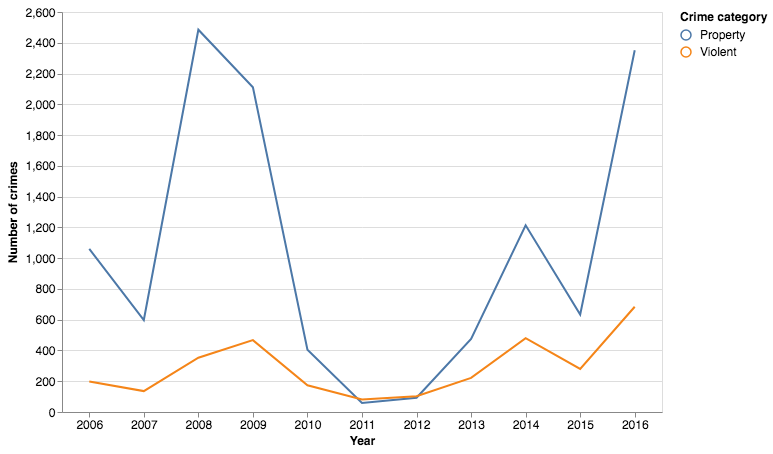

In [15]:
plot_missing = format_chart(alt.Chart(missing_df).mark_line().encode(
    alt.X('Date:O', axis=alt.Axis(labelAngle=0, title='Year')),
    alt.Y('n_missing:Q', axis=alt.Axis(title='Number of crimes')),
    alt.Color('Crime category:N')))
plot_missing

Should the following save command not work, you need to first install `selenium` and a corresponding driver for your web browser. Visit [the selenium documentation](http://selenium-python.readthedocs.io/installation.html) for more information.

In [19]:
plot_missing.save(str(project_root / 'reports/appendix/figures/plot_missing.png'), scale_factor=5)